In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
import pandas_profiling
import datetime
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data/uplift_train.csv')
df1 = pd.read_csv('data/clients.csv')
df2 = pd.read_csv('data/products.csv')
test = pd.read_csv('data/uplift_test.csv')

In [3]:
data_train = pd.merge(df1,df)
miss = data_train[data_train['first_redeem_date'].isna()]
miss['first_redeem_date']=miss['first_issue_date']
data_train.first_redeem_date[miss.index]=miss.first_redeem_date.values
data_train

,client_id,first_issue_date,first_redeem_date,age,gender,treatment_flg,target
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0,1
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,1
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,1
...,...,...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,0,0
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,0,1
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,0,1
200037,fffeca6d22,2017-12-28 11:56:13,2017-12-28 11:56:13,77,F,1,0


In [4]:
data_test=pd.merge(df1,test)
miss = data_test[data_test['first_redeem_date'].isna()]
miss['first_redeem_date']=miss['first_issue_date']
data_test.first_redeem_date[miss.index]=miss.first_redeem_date.values
data_test

,client_id,first_issue_date,first_redeem_date,age,gender
0,000048b7a6,2018-12-15 13:33:11,2018-12-15 13:33:11,68,F
1,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
2,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U
3,00007f9014,2017-08-22 13:35:01,2019-02-15 19:19:18,45,F
4,0000a90cf7,2017-05-20 12:34:50,2017-07-08 12:48:22,45,U
...,...,...,...,...,...
200118,fffeacbe3e,2017-07-19 08:38:17,2017-10-13 10:59:14,47,F
200119,fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U
200120,ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F
200121,ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F


In [5]:
data_train['first_issue_date']=pd.to_datetime(data_train['first_issue_date'])
data_train['first_redeem_date']=pd.to_datetime(data_train['first_redeem_date'])
data_test['first_issue_date']=pd.to_datetime(data_test['first_issue_date'])
data_test['first_redeem_date']=pd.to_datetime(data_test['first_redeem_date'])

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200039 entries, 0 to 200038
Data columns (total 7 columns):
client_id            200039 non-null object
first_issue_date     200039 non-null datetime64[ns]
first_redeem_date    200039 non-null datetime64[ns]
age                  200039 non-null int64
gender               200039 non-null object
treatment_flg        200039 non-null int64
target               200039 non-null int64
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 17.2+ MB


In [7]:
data_train = data_train[data_train['age']<90][data_train['age']>15]
data_test = data_test[data_test['age']<90][data_test['age']>15]

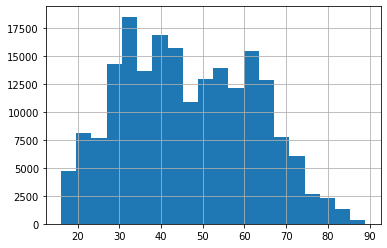

In [8]:
data_train.age.hist(bins=20)

In [9]:
data_train['first_issue_date'] = data_train['first_issue_date'].apply(lambda x: x.timestamp())

In [10]:
data_train['first_redeem_date'] = data_train['first_redeem_date'].apply(lambda x: x.timestamp())
data_test['first_issue_date'] = data_test['first_issue_date'].apply(lambda x: x.timestamp())
data_test['first_redeem_date'] = data_test['first_redeem_date'].apply(lambda x: x.timestamp())

In [11]:
purch = pd.read_csv('data/purchases.csv')

In [13]:
df2[df2['product_id']=='9a80204f78'].is_alcohol.values[0]

0

In [14]:
purch[purch['client_id']=='000012768d']

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
5,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,21db5dbe53,1.0,34.0,NaN
6,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,1e208d0b4c,1.0,24.0,NaN
7,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,15ccaa8685,1.0,51.0,NaN
8,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,45389bb5b0,1.0,23.0,NaN
9,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,cb4c804130,1.0,60.0,NaN


In [16]:
purch[purch['client_id']=='000012768d'].transaction_datetime.values[-1]

'2019-03-14 15:01:47'

In [17]:
purch[purch['client_id']=='000012768d'].transaction_id.value_counts()

7e3e2e3984    19
6a0e96d0bc    16
c1ca85d462    11
b34f23306e     6
Name: transaction_id, dtype: int64

In [18]:
purch[purch['client_id']=='000012768d'].purchase_sum.mean()

784.7884615384615

In [19]:
user_id = list(set(purch.client_id.values))

In [29]:
%%time
new_features = []
for user in user_id[:5]:
    a = []
    #user_id
    a.append(user)
    #число покупок
    a.append(len(purch[purch['client_id']==user].transaction_id.unique()))
    #дата последней покупки
    a.append(purch[purch['client_id']==user].transaction_datetime.values[-1])
    #средняя сумма покупки
    a.append(purch[purch['client_id']==user].purchase_sum.mean())
    #число различных магазинов
    a.append(len(purch[purch['client_id']==user].store_id.unique()))
    new_features.append(a)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [30]:
new_features

[['d6f2a8b014', 19, '2019-03-17 07:21:51', 126.25490196078431, 4],
 ['17eaff0e4c', 27, '2019-03-10 10:03:14', 1345.0753367875648, 4],
 ['24fe2adb20', 25, '2019-03-15 15:35:06', 920.5958518518519, 3],
 ['af31feec5e', 20, '2019-02-28 06:33:33', 776.457627118644, 3],
 ['0a32c56683', 30, '2019-03-12 11:49:36', 449.59091397849465, 3]]

In [200]:
df2.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [15]:
df.target.value_counts()

1    124002
0     76037
Name: target, dtype: int64

In [18]:
test.head()

,client_id
0,000048b7a6
1,000073194a
2,00007c7133
3,00007f9014
4,0000a90cf7


In [19]:
df1[df1['client_id']=='000048b7a6']

,client_id,first_issue_date,first_redeem_date,age,gender
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
